# Laboratorio: Técnicas de Segmentación - Clustering
# Santander Meteorology Group
# [Profesor de la sesión: Joaquín Bedia]


## Introducción

### Paquetes de R utilizados

Tanto la función `kmeans()` como `hclust()`, para el agrupamiento k-medias y jerárquico respectivamente, se encuentran por defecto listas para ser utilizadas en R, ya que pertenecen al paquete básico `stats`. A pesar de que principalmente utilizaremos estas técnicas, también utilizaremos otras librerías que nos permitan experimentar con otras metodologías o utilizar otras funcionalidades de interés. Adicionalmente, podría ser interesante (aunque no imprescindible) la utilización del paquete `sparcl`, que permite colorear las observaciones contenidas en un dendrograma de forma fácil en función de su grupo de pertenencia, para niveles diferentes de corte. Por último, mencionar que las técnicas basadas en _Gaussian Mixtures_ se encuentran implementadas en el paquete `mclust`.


In [1]:
## Required packages:
if (!require(FNN)) install.packages("FNN")
if (!require(MASS)) install.packages("MASS")
if (!require(stats)) install.packages("stats")
if (!require(caret)) install.packages("caret")
if (!require(e1071)) install.packages("e1071")
if (!require(mclust)) install.packages("mclust")
#if (!require(sparcl)) install.packages("sparcl")
if (!require(kohonen)) install.packages("kohonen")
if (!require(cluster)) install.packages("cluster")
if (!require(fields)) install.packages("fields")

Loading required package: FNN

Loading required package: MASS

Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2

Loading required package: e1071

Loading required package: mclust

Package 'mclust' version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.

Loading required package: kohonen


Attaching package: ‘kohonen’


The following object is masked from ‘package:mclust’:

    map


Loading required package: cluster

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwar

In [2]:
## Statistical tools:
library(MASS)
library(stats)

## Clustering methods:
library(mclust)
library(caret)
library(e1071)
library("sparcl", lib.loc =  "~/R/x86_64-pc-linux-gnu-library/3.6")
library(kohonen)
library(cluster)
library(FNN)

### Introducción general a los algoritmos de agrupamiento

Las técnicas de agrupamiento, o `clustering`, consisten en encontrar subgrupos dentro de un conjunto de observaciones dado. El objetivo es encontrar subconjuntos de observaciones que tienen un parecido mayor entre sí respecto a las observaciones pertenecientes a otros subgrupos. Para ello, es preciso definir alguna medida de `similitud`, lo que a menudo viene dado por el problema específico que se quiere resolver.

Este tipo de problemas de agrupamiento pertenecen al dominio del `aprendizaje no supervisado`, en el que intentamos descubrir una estructura subyacente en los datos (recuerda que en el `aprendizaje supervisado` intentábamos predecir alguna variable entrenando con un conjunto de datos cuyo resultado conocíamos previamente).

Tanto el `Análisis de Componentes Principales` (PCA) como las técnicas de agrupamiento tienen como objeto la simplificación de los datos a través de alguna forma de síntesis, pero operan de maneras diferentes:

 * El PCA tiene como objetivo la reducción de la dimensionalidad del espacio de las observaciones recogiendo una buena parte de la varianza.
 * Las técnicas de agrupamiento buscan subgrupos de observaciones homogéneos dentro del conjunto de las observaciones.

Las técnicas de `clustering` se aplican en multitud de dominios de análisis, y por lo tanto existe una gran variedad de ellas aplicadas a campos específicos. En este caso, vamos a ver dos de las técnicas más populares representativas de las dos familias principales, basadas en centroides o partición jerárquica: 

 * El algoritmo `k-medias` pertenece a la familia de las técnicas de agrupamiento no-divisivas y basadas en centroides. En el algoritmo `k-medias` conocemos de antemano el número de grupos que queremos obtener.
 * El algoritmo de agrupamiento `jerárquico` pertenece a la familia de las técnicas divisivas. En este caso desconocemos de antemano el número de grupos deseado. Lo que obtenemos es un diagrama con estructura de árbol, o `dendrograma` que permite visualizar el agrupamiento obtenido para cada número posible de grupos, desde 1 hasta $n$. 

Cada método tiene ventajas e inconvenientes que mostraremos a continuación.

### Agrupamiento k-medias

El algoritmo `k-medias` es un método sencillo para dividir un set de datos en $K$ grupos sin intersecciones, dado previamente el número de grupos ($K$) que queremos generar.

Para explicar el mecanismo, sencillo e intuitivo, mediante el que opera `K-medias`, sean $C_{1}$,... ,$C_{K}$ conjuntos que contienen los índices de las observaciones pertenecientes a cada cluster. Estos satisfacen dos propiedades:

 * todas las observaciones pertenecen al menos a un clúster.
 * los clusters nunca solapan: ninguna observación puede pertencer a más de un cluster (no obstante, existen técnicas de k-medias de tipo _fuzzy_, que asignan a cada observación una probabilidad de pertenencia a cada uno de los clusters generados).

La idea detrás de `K-medias` es que un agrupamiento es bueno cuando la variabilidad intra-grupos es lo más pequeña posible. Por otra parte, la variabilidad entre-grupos $C_{k}$ es una medida $W(C_{k})$ de cuánto difieren las observaciones pertenecientes a un grupo de las de otro. Por tanto, se pretende resolver el problema:

\begin{equation}\label{eq1}
\stackrel{\hbox{minimize}}{\hbox{$C_{1}, \dots ,C_{k}$}} \left\lbrace \sum_{k=1}^{K}W(C_{k}) \right\rbrace
\end{equation}

Dicho de otro modo, la ecuación (1) dice que queremos dividir las observaciones en $K$ grupos (`clusters`) de modo que se minimice la suma total de la variabilidad en cada cluster. Para resolver (1), debemos definir una medida de dicha variabilidad. Hay muchas métricas para esto, pero la más utilizada es el cuadrado de la `distancia Euclídea`. Es decir, definimos lo siguiente:

\begin{equation}\label{eq2}
W(C_{k}) = \frac{1}{|C_{k}|} \sum_{i,i' \in C_{k}} \sum_{j=1}^{p}(x_{ij} - x_{i'j})^{2},
\end{equation}

donde $|C_{k}|$ denota el número de observaciones en el cluster `k-ésimo`. Por tanto, la variabilidad intra-cluster es la suma de todas las distancias Euclídeas entre todos los pares de observaciones dentro de ese cluster, dividido por el número total de observaciones dentro de ese clúster. La combinación de las ecuaciones (1) y (2) presenta el problema de optimización que debe resolver el algoritmo `K-medias`:

\begin{equation}\label{eq3}
\stackrel{\hbox{minimize}}{\hbox{$C_{1}, \dots ,C_{k}$}} \left\lbrace \sum_{k=1}^{K} \frac{1}{|C_{k}|} \sum_{i,i' \in C_{k}} \sum_{j=1}^{p}(x_{ij} - x_{i'j})^{2} \right\rbrace.
\end{equation}

#### El algoritmo

Ahora se trata de encontrar un algoritmo capaz de resolver (3) --es decir, que divida las observaciones en $K$ grupos que minimicen la variabilidad intra-grupo--. Se trata de un problema difícil de resolver ya que puede dar lugar a un número muy alto de grupos distintos de $n$ observaciones en $K$ clusters ($K^n$). Existe no obstante un algoritmo sencillo capaz de encontrar un óptimo local (digamos una solución `bastante buena`) al problema de optimización expuesto en (3). A continuación presentamos dicho algoritmo:

 * Primero se asigna un número aleatorio, de 1 a $K$, a cada una de las observaciones. Este es el cluster de pertenencia inicial de cada observación.
 * Se procede iterando hasta que la pertenencia de cada observación al cluster deja de cambiar:
 * Para cada uno de los $K$ clusters, se calcula su `centroide`.
 * Asigna a cada observación al cluster cuyo centroide está más próximo (esta proximidad se determina en este caso mediante la distancia Euclídea)

Este algoritmo garantiza la reducción de la distancia intra-grupos en cada iteración, hasta alcanzar un `óptimo local`. Su nombre (`K-medias`) viene dado por el hecho de que en el paso 2(a) expuesto anteriormente, los centroides se calculan como la media de las observaciones en ese clúster.

Dado que la solución del algoritmo `K-medias` es un óptimo local (no global), los resultados obtenidos dependen de la condición inicial (la primera asignación aleatoria de clúster a las observaciones, paso 1), es importante ejecutarlo varias veces con diferentes inicializaciones para asegurar un buen agrupamiento. Esto queda reflejado en la figura 1.

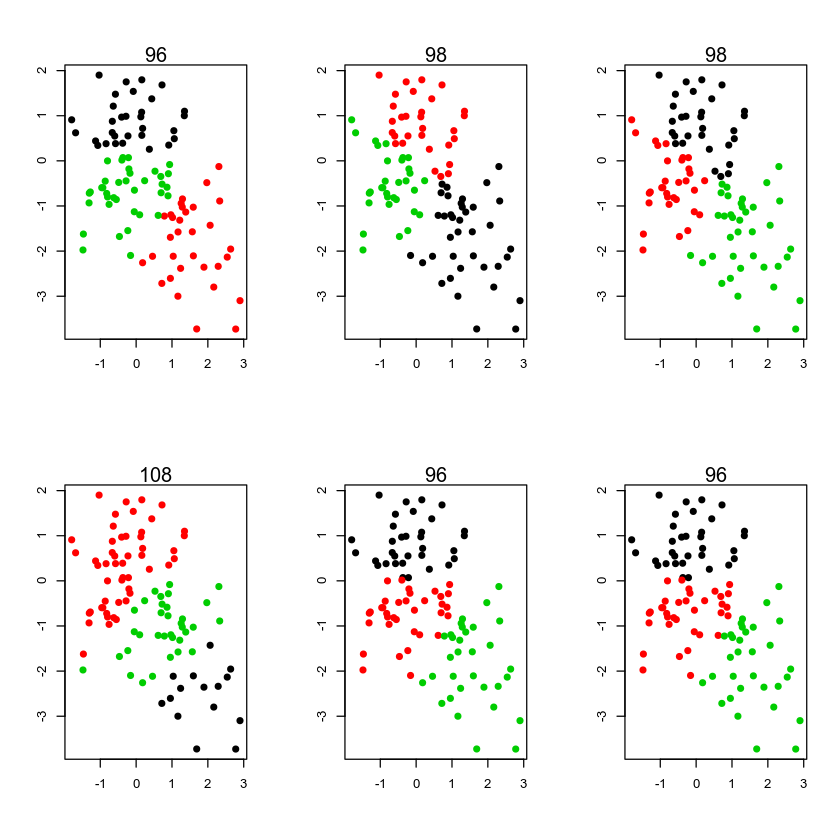

In [64]:
# GENERA FIGURA 1
set.seed(4)
x <- matrix(rnorm(100 * 2), ncol = 2)
x[1:25, 1] <- x[1:25, 1] + 1
x[1:25, 2] <- x[1:25, 2] - 2
k <- 3
par(mfrow = c(2,3))
j = 6
while(j > 0) {
      j <- j - 1
      set.seed(j+1)
      km <- kmeans(x, centers = k)
      plot(x, ty = "n", xlab = "", ylab = "")
      for (i in 1:k) {
            points(x[km$cluster == i, ], pch = 19, col = i)
      }
      mtext(format(km$tot.withinss, digits = 2)) 
}

### Agrupamiento jerárquico aglomerativo

A diferencia de `K-medias`, las técnicas de agrupamiento jerárquico no requieren un número predefinido de grupos, lo cual es una ventaja en muchas ocasiones. Además, produce una estructura de tipo árbol para representar el agrupamiento de los datos llamado `dendrograma`.

A continuación describimos  el tipo más común de clustering jerárquico, conocido como `de abajo hacia arriba` o `aglomerativo`, en referencia al hecho de que normalmente se representa como un árbol boca-abajo, que comienza a elaborarse por las hojas y va combinando clusters para formar ramas de forma progresiva hasta llegar a un tronco común.

#### El dendrograma

En esta sección utilizaremos el ejemplo mostrado en la figura 2, donde hay 45 observaciones que pertencen a grupos bien diferenciados. El clustering jerárquico (usando el método `complete linkage`, que veremos a continuación) prodice el resultado mostrado en la figura 3. ¿Cómo interpretamos el dendrograma?

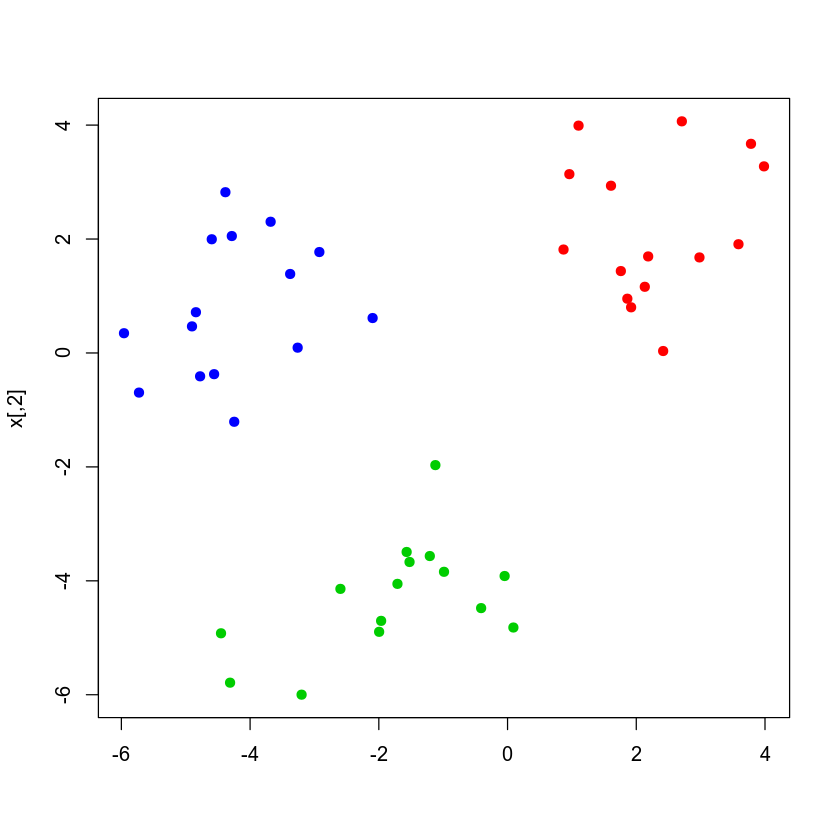

In [65]:
# GENERA FIGURA 2
set.seed(2)
x <- matrix(rnorm(45 * 2), ncol = 2)
x[1:15, 1] <- x[1:15, 1] + 2
x[1:15, 2] <- x[1:15, 2] + 2
x[16:30, 2] <- x[16:30, 2] - 4
x[16:30, 1] <- x[16:30, 1] - 2
x[31:45, 1] <- x[31:45, 1] - 4
x[31:45, 2] <- x[31:45, 2] + 1 
plot(x, ty = "n", xlab = "")
points(x[1:15, ], col = 2, pch = 19)
points(x[16:30, ], col = 3, pch = 19)
points(x[31:45, ], col = 4, pch = 19)

En el dendrograma de la figura \ref{fig:plot3} están representados los datos de la figura \ref{fig:plot2}, pero coloreados para diferentes niveles de agrupamiento. Los extremos inferiores (las hojas) corresponden a cada una de las observaciones. A medida que ascendemos por el árbol, algunas hojas comienzan a unirse para dar lugar a ramas. Estas observaciones son las más similares entre sí. A medida que nos movemos hacia arriba en el árbol, las ramas se van uniendo entre sí o con otras hojas. Cuanto antes se unen, más similitud hay entre los grupos de observaciones. Por el contrario, cuanto más lejana es la unión entre ramas, más alejados se encuentran entre sí los grupos de observaciones. La altura de estas uniones, medida en el eje vertical del dendrograma, mide la diferencia entre dos observaciones.

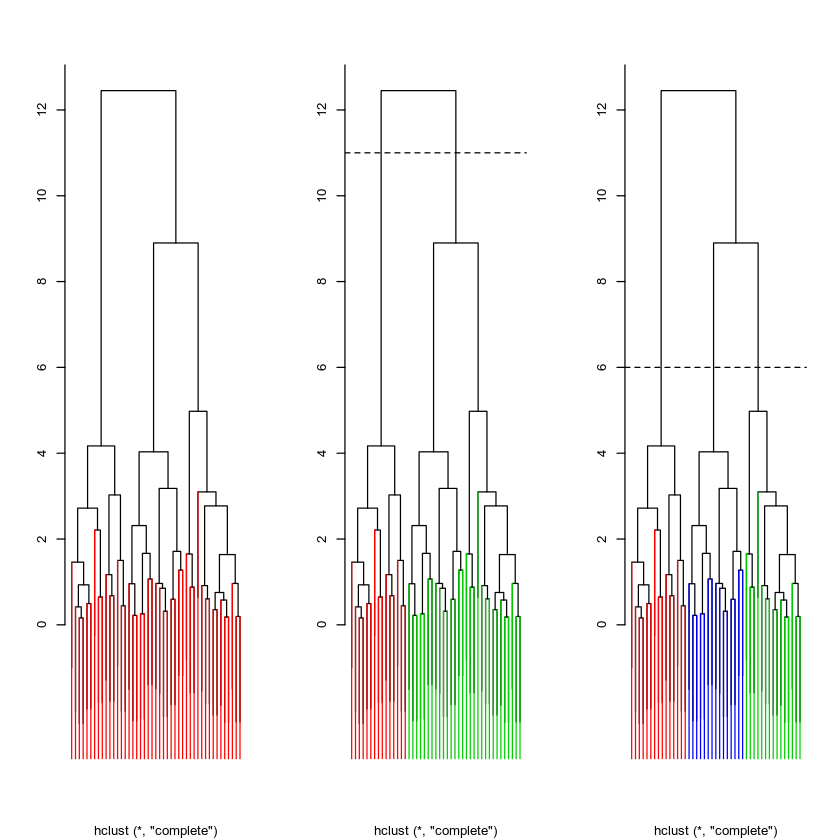

In [66]:
# GENERA FIGURA 3
require(sparcl) # colorea las hojas del dendrograma de forma facil
hc <- hclust(dist(x), method = "complete")
par(mfrow=c(1,3))
y1 <- cutree(hc, k = 1)
ColorDendrogram(hc, y = y1, ylab = "", xlab = "", branchlength = 10)
y2 <- cutree(hc, h = 11)
ColorDendrogram(hc, y = y2, ylab = "", xlab = "", branchlength = 10)
abline(h = 11, lty = 2)
y3 <- cutree(hc, h = 6)
ColorDendrogram(hc, y = y3, ylab = "", xlab = "", branchlength = 10)
abline(h = 6, lty = 2)

NOTA: No pueden extraerse conclusiones sobre la similitud entre dos observaciones por su posición en el eje horizontal. Por el contrario, debemos observar la primera unión de ambas observaciones y su punto de corte con el eje vertical. A modo de ejemplo, se presenta la figura 4: Los pares de observaciones (9,8) y (2,7) son muy similares entre sí (la distancia euclídea que los separa es pequeña, como puede verse en el plot de la izquierda). Sin embargo, la distancia entre (4,3) es considerable, y sin embargo aparecen seguidos en el eje horizontal. Puede comprobarse que su punto de unión en el eje vertical es el más alejado ($>4$). Por el contrario, las observaciones 1 y 7, alejadas entre sí en el eje horizontal, son mucho más próximas, cortando el eje vertical en un valor próximo a 2.

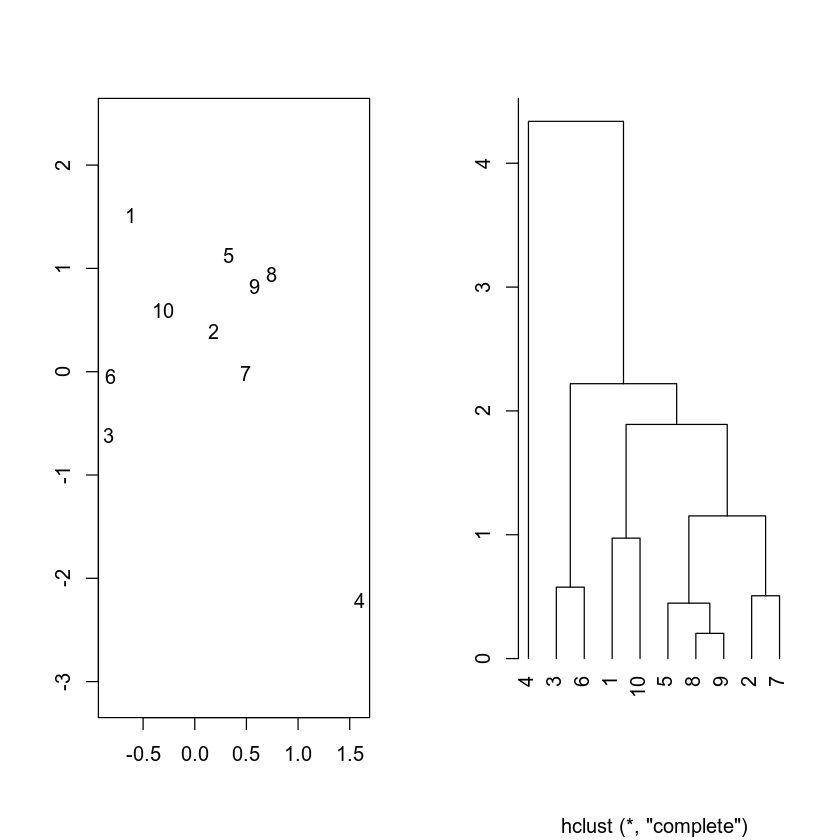

In [67]:
# GENERA FIGURA 4
set.seed(1)
x <- matrix(rnorm(20), ncol = 2)
hc <- hclust(dist(x))
par(mfrow = c(1,2))
plot(x, ty = "n", xlab = "", ylab = "", asp = 1)
text(x[hc$order,1], x[hc$order,2], hc$order)
plot(hc, xlab = "", ylab = "", main = "", hang = -1)

#### Identificación de grupos

Ahora que podemos interpretar un dendrograma, pasamos a analizar la identificación de los grupos que se han generado. Para ello, hacemos un corte horizontal en un punto dado del eje vertical, tal y como se indica con una línea punteada en los paneles central y derecho de la figura \ref{fig:plot3}. Los grupos de observaciones definidos bajo la línea de corte son los clusters resultantes. Como se ve en la figura 3, en el panel central, al trazar un corte a la altura de 11 generamos dos clusters diferentes. A medida que descendemos, el número de clusters aumenta. En el panel derecho, vemos que para un nivel de corte de 6 obtenemos 3 clusters. Descendiendo, se obtienen progresivamente más grupos, hasta llegar a tantos grupos como observaciones para un nivel de corte de 0. Por tanto, la altura de corte sirve para definir el número de grupos, tal y como el parámetro $K$ hacía en la técnica de las `K-medias`.

En la práctica, normalmente el número de grupos se suele seleccionar por inspección visual del dendrograma, buscándose un número de grupos razonable en función de las diferentes alturas y el número de clusters que se quiera obtener. No obstante, como se ve un único dendrograma puede servir para seleccionar distinto número de grupos. En el caso de la figura 3, el nivel de corte para obtener tres grupos parece el más razonable, sobretodo si tenemos en cuenta los datos de partida representados en la figura 2. Sin embargo, a veces la selección del número de grupos no es tan obvia. En este sentido, si tenemos un conocienito a priori del tipo de grupos que podríamos encontrar, el agrupamiento jerárquico podría no ser la mejor opción. 

#### Ejemplo gráfico

El dendrograma se obtienen mediante un algortimo muy sencillo. Se comienza por definir algún tipo de medida de distancia entre cada par de observaciones (típicamente la distancia Euclídea, aunque hay muchas otras, `? dist`). Se comienza desde la base del árbol, donde cada observación es tratada como un cluster independiente. A partir de ahí, de forma iterativa, se van uniendo los clusters más cercanos entre sí hasta llegar a un único cluster que engloba a todas las observaciones, momento en el que el dendrograma se completa y se para. Esto queda reflejado, para las 6 primeras iteraciones, en la figura 5, que se corresponde con los datos mostrados anteriormente en el dendrograma de la figura 4. 

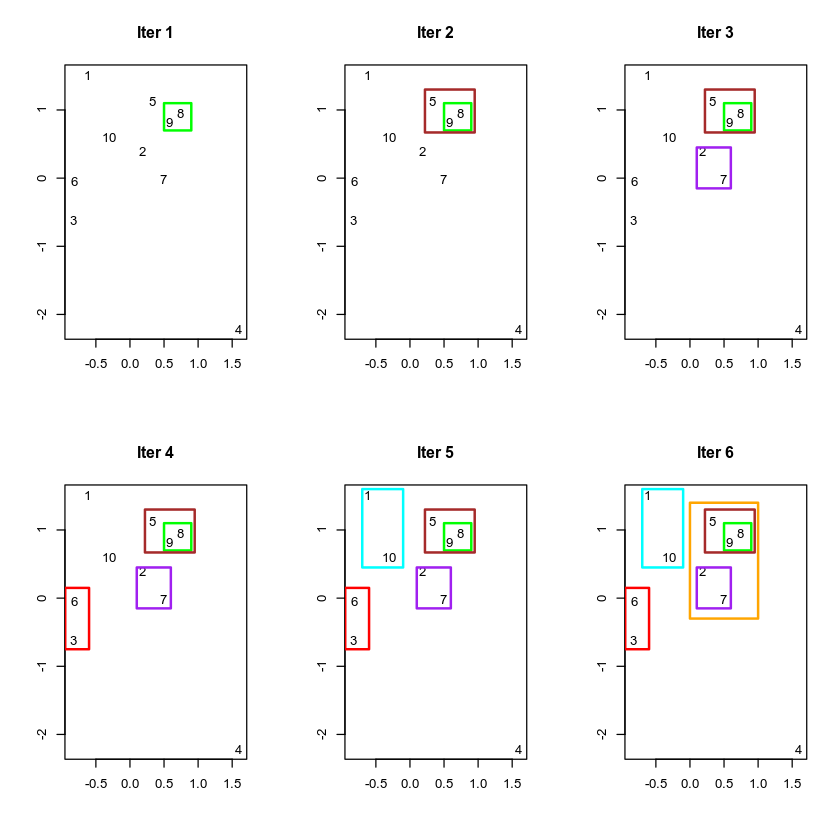

In [68]:
## GENERA FIGURA 5

set.seed(1)
x <- matrix(rnorm(20), ncol = 2)
hc <- hclust(dist(x))
par(mfrow = c(2,3))
# plot(x, ty = "n", xlab = "", ylab = "", asp = 1, main = "Iter 1")
# text(x[hc$order,1], x[hc$order,2], hc$order)
plot(x, ty = "n", xlab = "", ylab = "", asp = 1, main = "Iter 1")
text(x[hc$order,1], x[hc$order,2], hc$order)
rect(0.5,0.7,0.9,1.1, border = "green", lwd = 2)

plot(x, ty = "n", xlab = "", ylab = "", asp = 1, main = "Iter 2")
text(x[hc$order,1], x[hc$order,2], hc$order)
rect(0.5,0.7,0.9,1.1, border = "green", lwd = 2)
rect(0.22,0.67,0.95,1.3, border = "brown", lwd = 2)

plot(x, ty = "n", xlab = "", ylab = "", asp = 1, main = "Iter 3")
text(x[hc$order,1], x[hc$order,2], hc$order)
rect(0.5,0.7,0.9,1.1, border = "green", lwd = 2)
rect(0.22,0.67,0.95,1.3, border = "brown", lwd = 2)
rect(0.1,-0.15,0.6,0.45, border = "purple", lwd = 2)

plot(x, ty = "n", xlab = "", ylab = "", asp = 1, main = "Iter 4")
text(x[hc$order,1], x[hc$order,2], hc$order)
rect(0.5,0.7,0.9,1.1, border = "green", lwd = 2)
rect(0.22,0.67,0.95,1.3, border = "brown", lwd = 2)
rect(0.1,-0.15,0.6,0.45, border = "purple", lwd = 2)
rect(-0.95,-0.75,-0.6,0.15, border = "red", lwd = 2)

plot(x, ty = "n", xlab = "", ylab = "", asp = 1, main = "Iter 5")
text(x[hc$order,1], x[hc$order,2], hc$order)
rect(0.5,0.7,0.9,1.1, border = "green", lwd = 2)
rect(0.22,0.67,0.95,1.3, border = "brown", lwd = 2)
rect(0.1,-0.15,0.6,0.45, border = "purple", lwd = 2)
rect(-0.95,-0.75,-0.6,0.15, border = "red", lwd = 2)
rect(-0.7,0.45,-0.1,1.6, border = "cyan", lwd = 2)

plot(x, ty = "n", xlab = "", ylab = "", asp = 1, main = "Iter 6")
text(x[hc$order,1], x[hc$order,2], hc$order)
rect(0.5,0.7,0.9,1.1, border = "green", lwd = 2)
rect(0.22,0.67,0.95,1.3, border = "brown", lwd = 2)
rect(0.1,-0.15,0.6,0.45, border = "purple", lwd = 2)
rect(-0.95,-0.75,-0.6,0.15, border = "red", lwd = 2)
rect(-0.7,0.45,-0.1,1.6, border = "cyan", lwd = 2)
rect(0,-0.3,1,1.4, border = "orange", lwd = 2)

**Algoritmo de agrupamiento jerárquico aglomerativo**

 * Se comienza con un set de $n$ observaciones y una medida de distancia (p.ej. la distancia euclídea) entre cada par ${n \choose 2} = \frac{n(n-1)}{2}$ de disimilitudes. Cada observación es un cluster.
 * Para $i = n, n-1, \dots ,2$:
 * Se examinan todas las disimilitudes entre los $i$ clusters y se identifica el par de clusters cuya disimilitud es menor (es decir, más cercanos). Se unen ambos. La disimilitud entre ambos indica la altura en el eje vertical del dendrograma, a la cual se sitúa el punto de unión entre ambos grupos.
 * Se calcula las nuevas disimilitudes entre pares de observaciones intra-cluster para los $n-1$ clusters restantes. 

Uniones entre clusters:

Como se ve, el algoritmo es sencillo, aunque falta por definir con más claridad cómo definir las uniones. Entre pares de observaciones sueltas está claro que la disimilitud se mide en función de la distancia entre ellas, pero ¿cómo definir la disimilitud entre dos clusters cuando uno de ellos o ambos contienen varias observaciones? (p. ej., el paso 2 o el paso 6 reflejados en la figura anterior. Hay varios métodos de unión (en inglés `linkage`), algunos de los cuales (los principales) están resumidos brevemente al final de este párrafo. Los más populares en análisis estadístico son del tipo `completa` (esta es la opción por defecto en la función de R `hclust`, {`complete`}), `promedio` (`average`) y `única` (`single`). Media y completa tienden a producir dendrogramas más equilibrados. Las disimilitudes calculadas en el paso (2b) por el algoritmo dependen directamente del tipo de unión seleccionado así como de la medida de disimilitud, afectando de manera muy importante al dendrograma resultante. En general, es importante seleccionar la medida de distancia en función de los datos analizados y el tipo de respuesta que se pretende obtener. En ocasiones, puede ser preferible obtener medidas de disimilitud basadas en correlación entre observaciones en lugar de su distancia.

A continuación se muestra un resumen de los principales tipos de unión consideradas en la formación de los grupos:

 * **Unión Completa** (_Complete linkage_): Maxima disimilitud entre grupos. Calcula todas las disimilitudes entre pares de observaciones dentro del cluster A y dentro del cluster B, y guarda `la mayor` de ellas. 
 * **Unión única** (_Single linkage_): Mínima disimilitud `intra`-grupos. Calcula todas las disimilitudes entre pares de observaciones dentro del cluster A y dentro del cluster B, y guarda `la menor` de ellas. Puede dar lugar a dendrogramas muy ramificados en que las observaciones se unen de una en una en cada iteración.
 * **Unión Promedio(Mediana)** (_Average(Median) linkage_): Disimilitud media(mediana) entre clusters. Calcula todas las disimilitudes entre pares de observaciones dentro del cluster A y dentro del cluster B, y guarda `la media`(mediana) de todas ellas.
 * **Unión por centroides** (_Centroid linkage_): Calcula la disimilitud entre el centroide del cluster A (un vector de medias de longitud $p$) y el centroide del cluster B. La unión entre centroides puede dar lugar a agrupamientos no deseables.
 * **Unión de Ward**: El criterio para seleccionar la pareja de grupos a unir en el siguiente paso viene dada por una función objetivo a minimizar/maximizar, definida por el usuario. En general, por defecto suele ser el método de mínima varianza, es decir, la suma de cuadrados de los errores (_Ward's minimum variance method_).


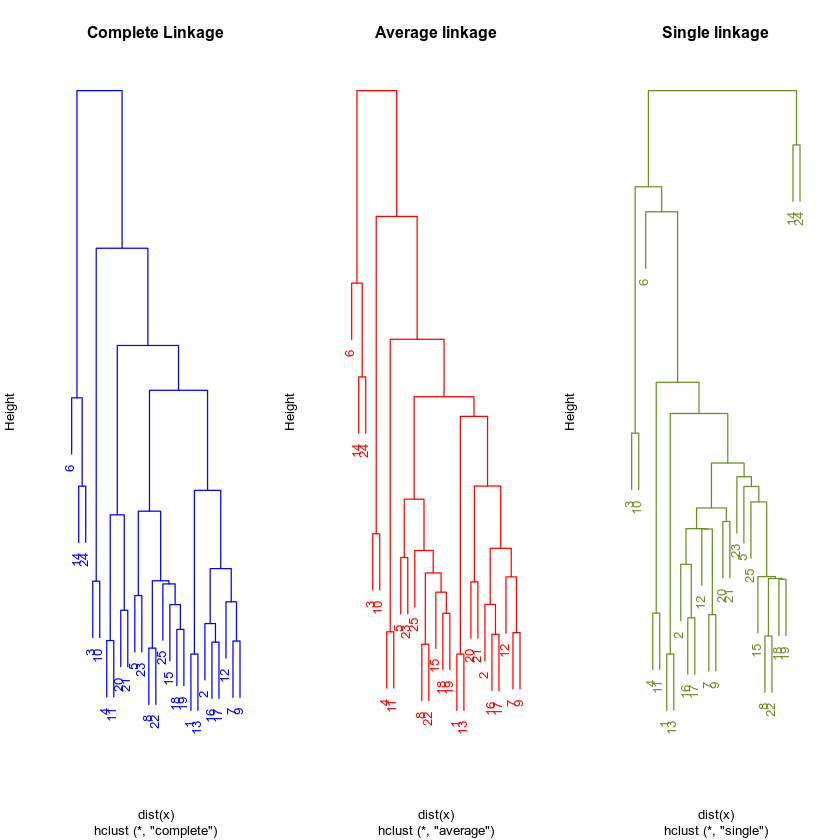

In [69]:
# GENERA FIGURA 6

set.seed(1)
x <- matrix(rnorm(50), ncol = 2)
par(mfrow=c(1,3))
plot(hclust(dist(x), method = "complete"), col = "blue", axes = FALSE,
     main = "Complete Linkage")
plot(hclust(dist(x), method = "average"), col = "red", axes = FALSE,
     main = "Average linkage")
plot(hclust(dist(x), method = "single"), col = "olivedrab", axes = FALSE,
     main = "Single linkage")

### Comentarios finales sobre las técnicas de agrupamiento y su aplicación práctica:

Aunque las técnicas de agrupamiento pueden resultar extremadamente útiles en el campo del aprendizaje no supervisado, deben tenerse en cuenta varios aspectos prácticos para su uso adecuado.

Algunas decisiones importantes que deben realizarse:

 * ¿Debemos estandarizar los datos de alguna manera antes de comenzar con el agrupamiento?
 * En el caso del agrupamiento jerárquico:
 * ¿Qué medida de distancia debemos escoger? 
 * ¿Qué tipo de unión aplicar?
 * ¿Qué punto de corte seleccionar para determinar el número de grupos resultante?
 * En el caso del agrupamiento K-medias, ¿cuántos grupos fijar?

Todas estas decisiones tienen una repercusión importante en los resultados finales. En la práctica, no suele haver una única opción válida sino varias. Normalmente se buscan referencias previas en la literatura o bien se realizan diversas pruebas hasta dar con un resultado razonable y fácilmente interpretable.

Siempre que apliquemos una técnica de clustering obtendremos un agrupamiento determinado de los datos. Por ejemplo, en la figura 6 hemos utilizado números generados de forma aleatoria sobre una distribución normal, lo cual desde un punto de vista práctico no tiene mucho sentido intentar agrupar. Del mismo modo, la presencia de extremos, u observaciones fuera de rango, puede distorsionar en gran medida la configuración de los grupos generados. Además, los métodos de agrupamiento en general son bastante sensibles a perturbaciones de los datos de entrada, por lo que modificaciones pequeñas en el set de observaciones puede dar lugar a cambios importantes en la asignación de los grupos.



## Aplicación práctica con R

En esta práctica ilustraremos de forma básica la implementación en R de las técnicas de agrupamiento k-medias y jerárquica. En la primera parte del guión ya has podido ver el código utilizado para generar las figuras. Ahora se trata de practicar este código y ver algún detalle más que puede ser interesante.


### Clustering con k-medias

El paquete `stats`, que se encuentra contenido en la instalación básica de R y cargado por defecto en la sesión de trabajo, contiene la función `k-means` que implementa el algoritmo `k-medias`.

#### Ejemplo con el dataset `iris`

Para comenzar a ilustrar su funcionamiento, vamos a considerar el dataset `iris` que ya hemos utilizado anteriormente, en el que hay una clase separable y otras dos no separables:

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


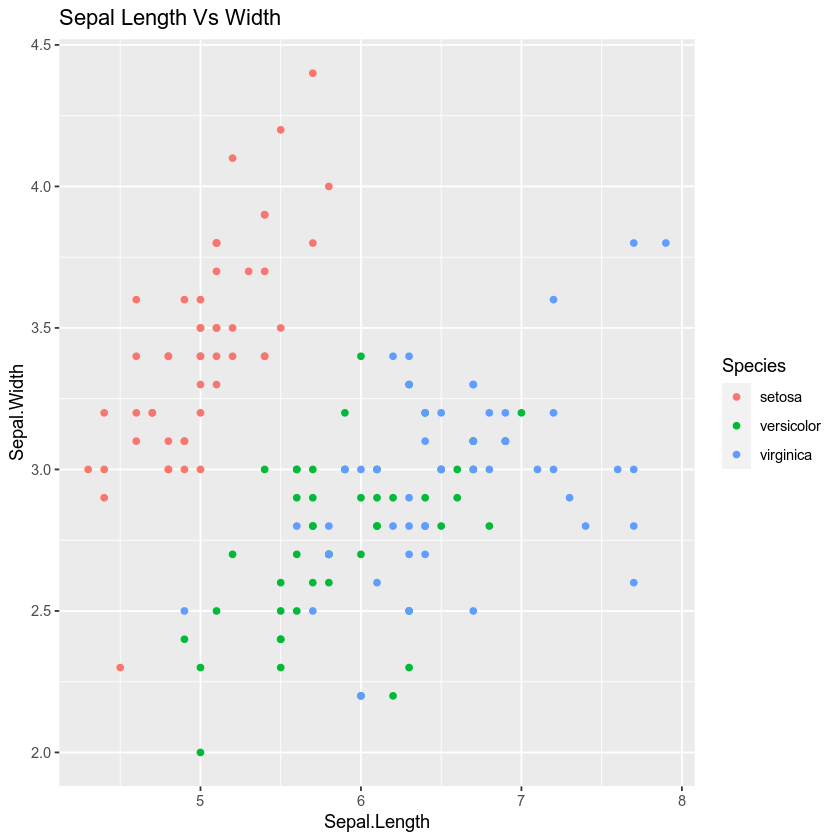

In [70]:
str(iris)
library(ggplot2)
ggplot( data = iris, 
  aes(x = Sepal.Length,y = Sepal.Width)) +  
  geom_point(aes(color= Species)) +
  ggtitle("Sepal Length Vs Width")

A continuación realizamos el clustering usando `kmeans`, indicando que deseamos tener tres grupos diferentes (argumento `centers = 3`):

             Length Class  Mode   
cluster      150    -none- numeric
centers       12    -none- numeric
totss          1    -none- numeric
withinss       3    -none- numeric
tot.withinss   1    -none- numeric
betweenss      1    -none- numeric
size           3    -none- numeric
iter           1    -none- numeric
ifault         1    -none- numeric

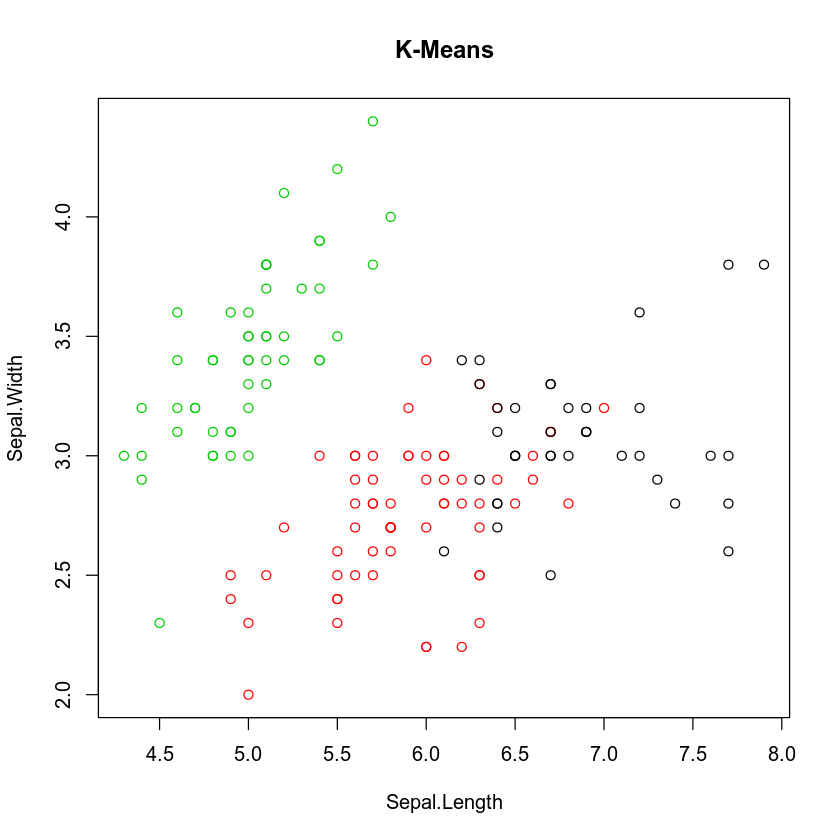

In [71]:
kmModel<-kmeans(iris[,-5],3,nstart=1)
summary(kmModel)
## Point center of two attributes
plot(iris[,c(1,2)],col=kmModel$cluster,main="K-Means")

La pertenencia de cada observación a los clusters indicados está contenida en el elemento `cluster` del objeto de salida, así como las distancias inter- e intra-grupo: 

In [72]:
kmModel$cluster
kmModel$withinss ## Vector of within-cluster sum of squares, one component per cluster
kmModel$betweenss ## The between-cluster sum of squares

[1] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [38] 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 1
[112] 1 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 1 2 1
[149] 1 2

[1] 23.87947 39.82097 15.15100

[1] 602.5192

Dado que en este caso tenemos las clases, podemos evaluar los grupos obtenidos:

In [73]:
confusionMatrix(as.factor(as.numeric(iris[,5])),as.factor(kmModel$cluster))

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1  0  0 50
         2  2 48  0
         3 36 14  0

Overall Statistics
                                         
               Accuracy : 0.32           
                 95% CI : (0.2463, 0.401)
    No Information Rate : 0.4133         
    P-Value [Acc > NIR] : 0.9925521      
                                         
                  Kappa : -0.02          
                                         
 Mcnemar's Test P-Value : 0.0003852      

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.0000   0.7742   0.0000
Specificity            0.5536   0.9773   0.5000
Pos Pred Value         0.0000   0.9600   0.0000
Neg Pred Value         0.6200   0.8600   0.5000
Prevalence             0.2533   0.4133   0.3333
Detection Rate         0.0000   0.3200   0.0000
Detection Prevalence   0.3333   0.3333   0.3333
Balanced Accuracy      0.2768   0.8757   0.2500

Notar que la evaluación del clustering depende de la interpretación de las etiquetas obtenidas y su correspondencia con las clases originales. Por otra parte, la inicialización aleatoria de los centroides da lugar a diferentes agrupaciones y correspondencias:

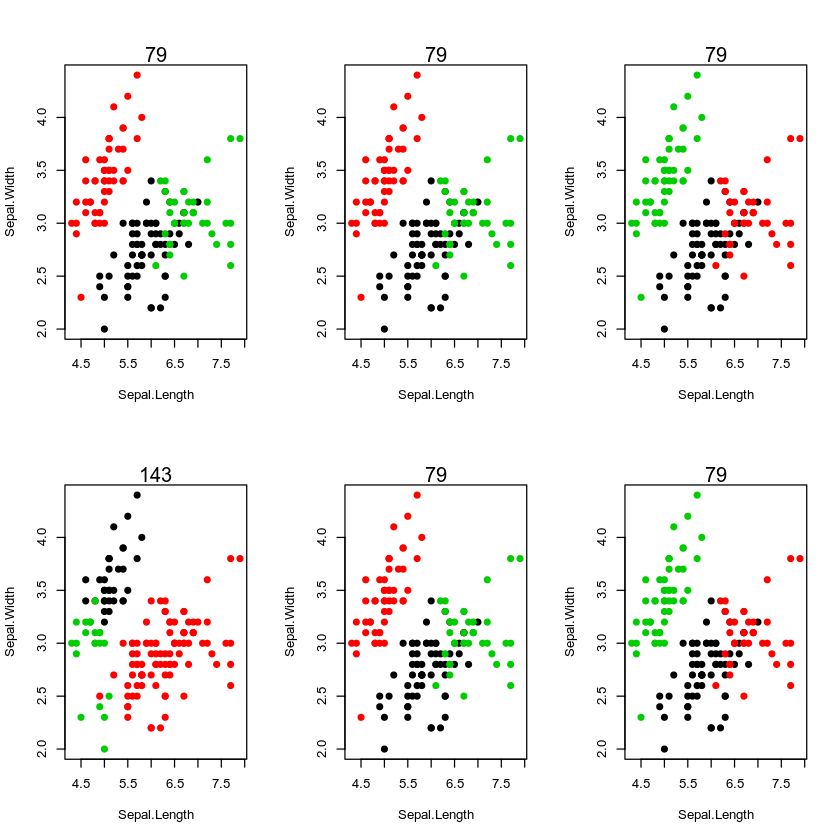

In [74]:
k <- 3
par(mfrow = c(2,3))
j <- 6
while (j>0) {
  set.seed(j)
  j <- j-1
  km <- kmeans(iris[ ,-5], centers = k)
  plot(iris[ ,c(1,2)], type = "n")
  for(i in 1:k){
      points(iris[km$cluster==i, c(1,2)], pch = 19, col = i)
  }
  mtext(format(km$tot.withinss, digits = 2))
}

El elemento `km$tot.withinss` es la suma de cuadrados total de la variación `intra-cluster`, que es precisamente la que se intenta minimizar a través del algoritmo k-medias. Las sumas de cuadrados individuales para cada cluster están almacenadas en `km$withinss`. Es recomendable hacer uso del argumento `nstart` siempre, y con un valor suficientemente alto (digamos 20 - 50),  para que el algoritmo se ejecute varias veces y asegurar que no nos quedamos atrapados en un óptimo local que no proporcione una separación óptima de los grupos. Además, es importante el uso de `set.seed()`, de modo que se asegura que la asignación aleatoria de clusters en el paso 1 del algoritmo puede replicarse, y su resultado sea perfectamente reproducible.

Como vemos, el algoritmo es capaz de realizar la separación de la clase linealmente separable pero tiene dificultades, como era de esperar, al separar los otros grupos.

En el ejemplo anterior sabíamos de antemano que los datos estaban agrupados en tres clusters. Sin embargo, en aplicaciones reales, normalmente desconocemos el número de grupos subyacente por lo que en ocasiones debemos probar varias combinaciones y evaluar, en base a algún parámetro del modelo, que `k` es óptimo.

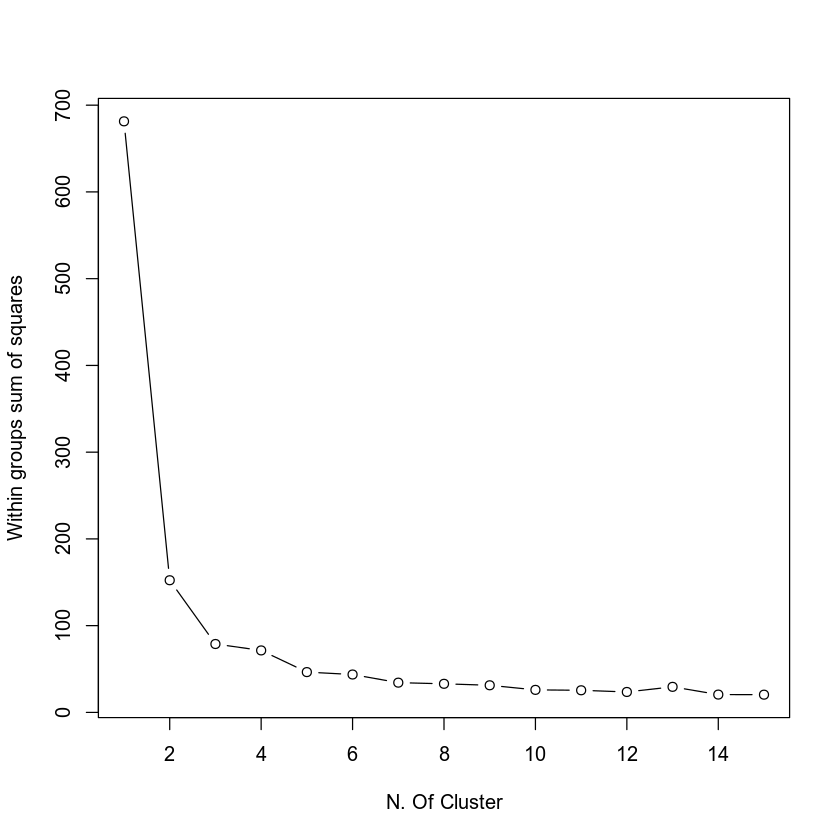

In [75]:
## How much clusters should we use?
totWithinss <- c(1:15)
for (i in 1:15) {
  kmModel<-kmeans(iris[,-5], centers = i, nstart = 1)
  totWithinss[i] <- kmModel$tot.withinss
}
plot(x=1:15, y=totWithinss, type="b",
  xlab = "N. Of Cluster", ylab = "Within groups sum of squares")

## Ejemplo con el MNIST dataset de Kaggle

### Ejemplo 1: Clustering como método de clasificación

En algunos casos, tenemos un conocimiento previo del número de clases que queremos identificar. En estos casos, ¿es posible utilizar un método de clustering como un método de clasificación? Esta pregunta es la que trataremos de responder en esta práctica. Para ello, aplicaremos un algoritmo de clustering al dataset [MNIST](https://www.kaggle.com/c/digit-recognizer/data), ya descrito en prácticas anteriores y analizamos si es capaz de separar correctamente los diferentes dígitos del 0 al 9.

In [8]:
# Reading the dataset
mnist_data <- read.csv("/home/juaco/DOCENCIA/2021_2022/M1966/datasets/MNIST_train.csv", sep = ",", header = TRUE)
# Launching the k-means clustering:
set.seed(1)
kmModel <- kmeans(mnist_data[, -1], centers = 10, nstart = 1)

In [9]:
str(kmModel)

List of 9
 $ cluster     : int [1:3627] 10 1 10 8 1 5 2 6 5 6 ...
 $ centers     : num [1:10, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:10] "1" "2" "3" "4" ...
  .. ..$ : chr [1:784] "pixel0" "pixel1" "pixel2" "pixel3" ...
 $ totss       : num 1.25e+10
 $ withinss    : num [1:10] 9.46e+08 4.87e+08 9.47e+08 9.29e+08 1.31e+09 ...
 $ tot.withinss: num 9.34e+09
 $ betweenss   : num 3.19e+09
 $ size        : int [1:10] 303 238 294 379 468 445 370 222 305 603
 $ iter        : int 8
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


Para evaluar de forma rápida la clasificación, dibujamos en forma de histogramas las frecuencias de cada clase según el cluster de pertenencia:

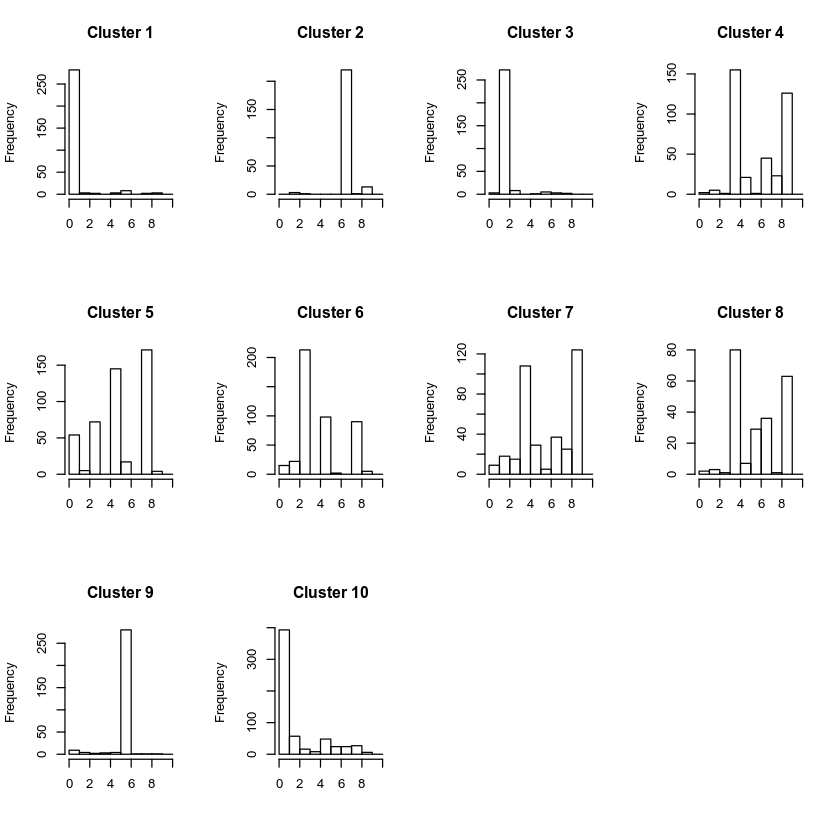

In [10]:
# Evaluating the discrimination:
par(mfrow = c(3, 4))
for (i in 1:10) {
    hist(mnist_data$label[which(kmModel$cluster == i)], xlab = "", 
        main = paste("Cluster", i), breaks = seq(0, 10, 1))
}

Los histogramas reflejan ciertas cifras que se discriminan correctamente si bien en otros clusters existe una mayor disparidad. Veamos los centroides asociados a cada cluster a ver si se corresponden con la cifra reflejada en el histograma:

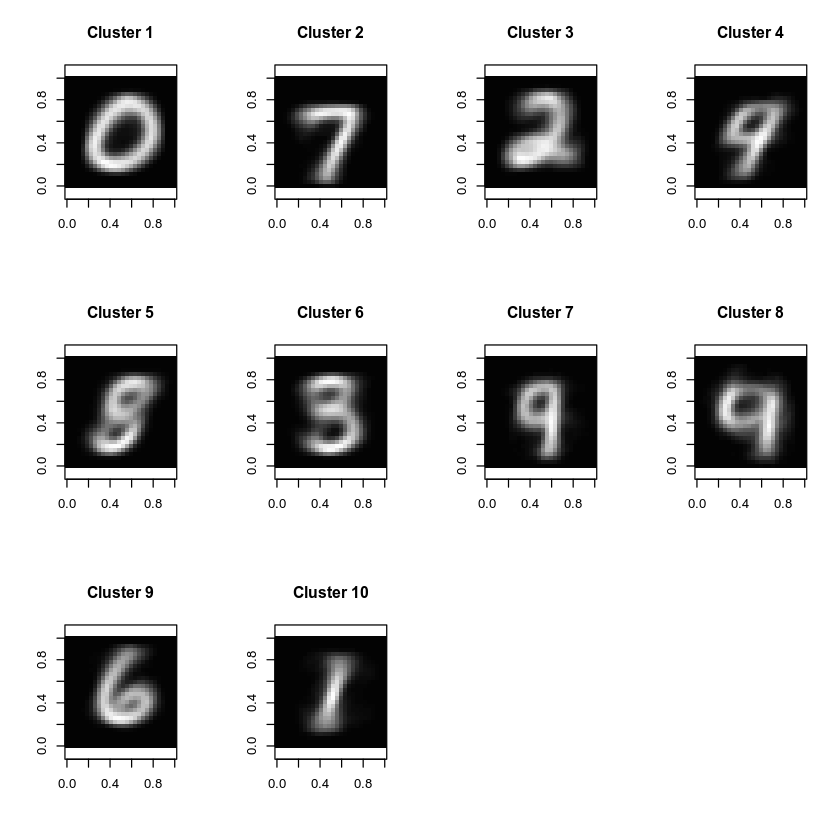

In [6]:
# Building a 3*4 grid
par(mfrow = c(3, 4))
for (i in 1:10) {
    # Converting i-th center to matrix
    mat <- matrix(rev(as.numeric(kmModel$centers[i, ])), nrow = 28, ncol = 28, byrow = FALSE)
    # plot (with a trick to re-order adequately for visualization)
    image(mat[28:1,], main = paste("Cluster", i), col = paste("gray", 1:99, sep = ""), 
        asp = 1)
}

Podemos inspeccionar individualmente las instancias clasificadas dentro de cada grupo, para indagar un poco en el resultado de la clasificación. Veamos por ejemplo los 100 primeros individuos del cluster 1:

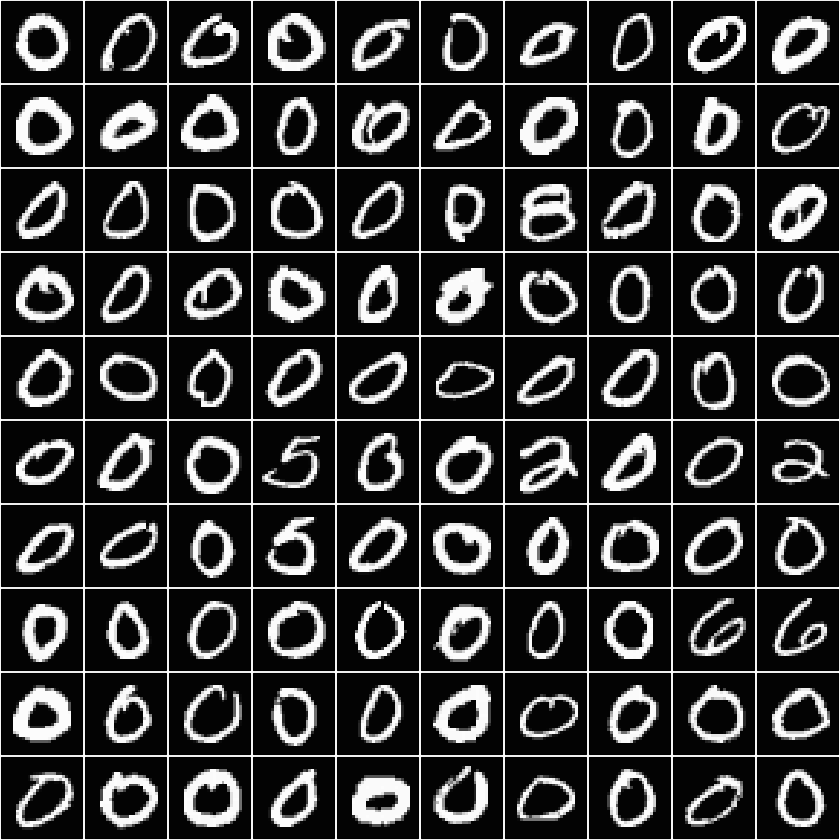

In [7]:
# Selección del cluster 1 
cl <- mnist_data[which(kmModel$cluster == 1), -1]

# Partición de la ventana gráfica en una matriz de 10x10 para meter 100 observaciones:
layout(matrix(1:100, ncol = 10), respect = FALSE)

# Separacion de cada celda de la matriz por un margen de 0.1 unidades relativas
par(mar = c(0.1, 0.1, 0.1, 0.1))

# Representación como imagen de 28x28 pixeles de cada una de las cifras:
for (i in 1:100) {
    mat <- matrix(rev(as.numeric(cl[i,])), nrow = 28, ncol = 28, byrow = FALSE)
    # plot (with a trick to re-order adequately for visualization)
    image(mat[28:1, ], main = NULL, xaxt = "n", yaxt = "n",  col = paste("gray", 1:99, sep = ""), asp = 1)    
}


***

**NOTA**: En este punto, es conveniente encapsular el código que realiza los histogramas y realiza las imágenes de los centroides y las observaciones para simplificar el código posterior. Creamos funciones específicas a tal efecto a continuación:

***

Por conveniencia, creamos las funciones `drawFrequencies`, `drawCentroids` y `drawClusterIndividuals`:

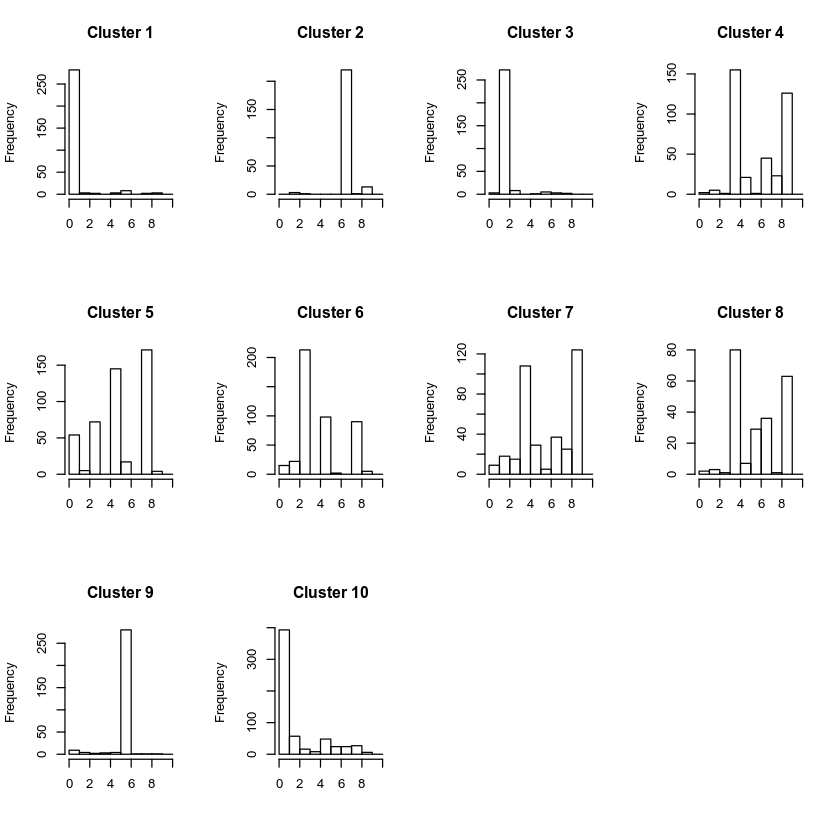

In [81]:
#' @description Function to draw the histograms for MNIST clusters
#' @param kmeans.object Output of function kmeans
#' @param labels Observed class
#' @note The user must decide the number of panels to be displayed via par(mfrow)

drawFrequencies <- function(kmeans.object, labels) {
    nclusters <- nrow(kmeans.object$centers)
    for (i in 1:nclusters) {
        hist(labels[which(kmeans.object$cluster == i)], xlab = "", main = paste("Cluster", 
            i), breaks = seq(0, nclusters, 1))
    }
}

## Example application:
par(mfrow = c(3, 4))
drawFrequencies(kmModel, mnist_data$label)

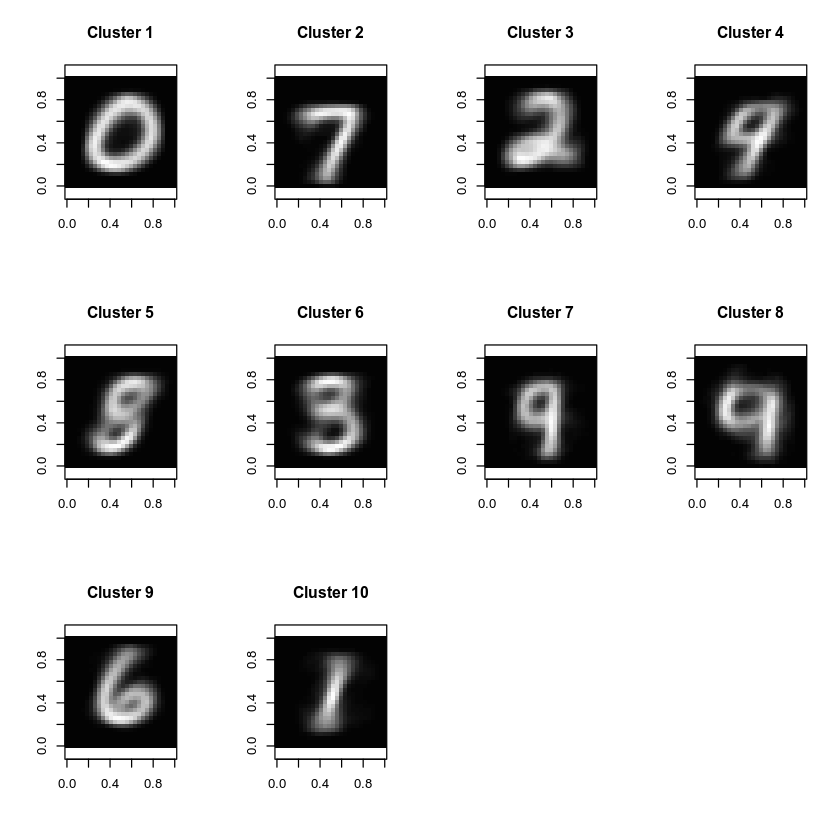

In [82]:
#' @description Function to draw kmeans clustering centroids for MNIST
#' @param kmeans.object Output of function kmeans
#' @note The user must decide the number of panels to be displayed via par(mfrow)

drawCentroids <- function(kmeans.object) {
    nclusters <- nrow(kmeans.object$centers)
    for (i in 1:nclusters) {
        # Converting i-th center to matrix
        mat <- matrix(rev(as.numeric(kmeans.object$centers[i, ])), nrow = 28, ncol = 28, 
            byrow = FALSE)
        # plot (with a trick to re-order adequately for visualization)
        image(mat[28:1, ], main = paste("Cluster", i), col = paste("gray", 1:99, 
            sep = ""), asp = 1)
    }
}

## Example application:
par(mfrow = c(3, 4))
drawCentroids(kmModel)

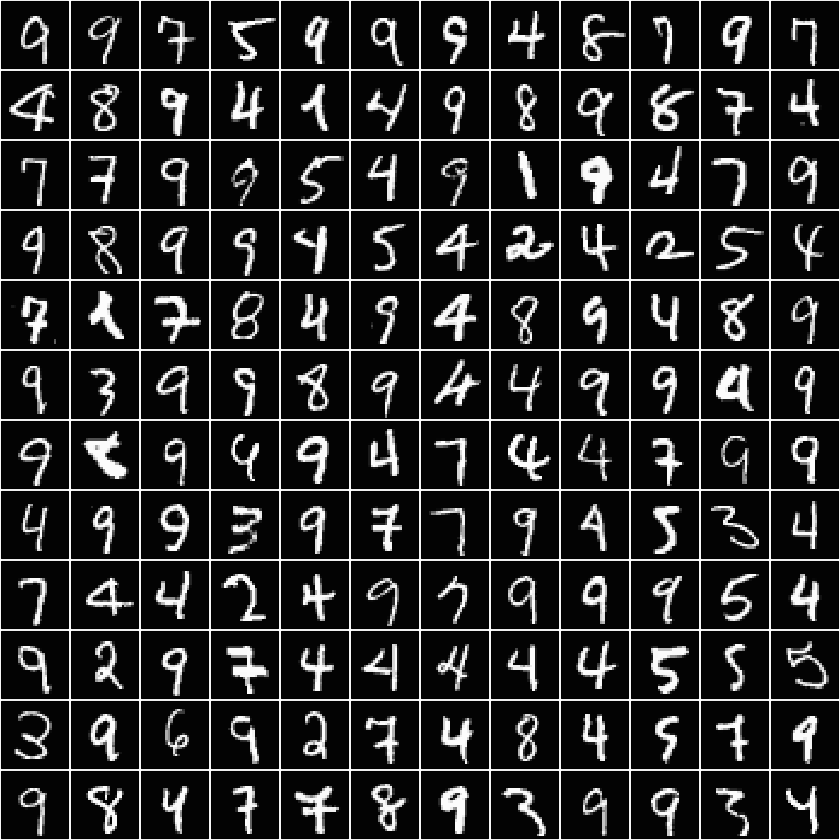

In [83]:
#' @description Function to draw the first N individuals belonging to a specified cluster
#' @param kmeans.object Output of function kmeans
#' @param cluster Integer value indicating the cluster to be displayed
#' @param dim Dimension of the squared matrix to display the results (Default is 100, that displays the first 100 individuals of the cluster in a 10x10 matrix).

drawClusterIndividuals <- function(kmeans.object, cluster, dim = 10) {
    cl <- mnist_data[which(kmModel$cluster == cluster), -1]
    #par(mfrow = c(5, 5))
    layout(matrix(1:(dim^2), ncol = dim), respect = FALSE)
    par(mar = c(.1, .1, .1, .1))
    for (i in 1:(dim^2)) {
    mat <- matrix(rev(as.numeric(cl[i,])), nrow = 28, ncol = 28, byrow = FALSE)
        # plot (with a trick to re-order adequately for visualization)
        image(mat[28:1, ], main = NULL, xaxt = "n", yaxt = "n", 
              col = paste("gray", 1:99, sep = ""), asp = 1)    
    }
}

## Example application (12x12 = 144 first individuals)
drawClusterIndividuals(kmModel, cluster = 7, dim = 12)

### Preguntas

#### Pregunta 1

Como se ve en la imagen, el orden de los clústeres no se corresponde, o no tiene por qué hacerlo, con el de las cifras, surgiendo una primera pregunta, ¿qué cifra asignamos a cada clúster?



#### Pregunta 2

Por otro lado, ¿quedan todas las cifras bien clasificadas a través del clustering? Calcula una medida de la bondad o error de la clasificación

#### Pregunta 3

Uno de los parámetros que podríamos ajustar es el número de iteraciones del algoritmo. Siguiendo el procedimiento anterior, ¿qué ocurre al incrementar el número de iteraciones? ¿permite conseguir una mejor discriminación de las 10 cifras? Justificar observando los nuevos centroides y viendo el error/bondad de la nueva clasificación.


#### Pregunta 4

Otro parámetro importante es el número de ciclos de entrenamiento, dado que como hemos visto k-medias puede deterse al encontrar una solución sub-óptima, como pudiera ser el caso. Para asegurar que se alcanza una solución óptima, será necesario inicializar repetidas veces el algoritmo, y retener aquella realización que obtenga un mejor resultado (en general aquella que muestre una suma de cuadrados total menor considerando la distancia entre centroides). Aumenta el número de inicializaciones y compara el resultado.

### Ejemplo 2. Aplicando PCA

En el tema de reducción de la dimensión, aplicamos el análisis de componentes principales a este dataset viendo que podría reducirse considerablemente su dimensión. Considerando un número "razonable" de componentes principales, vamos a aplicar el clustering sobre los mismos datos: 

In [97]:
# PCA with R
PCA <- prcomp(mnist_data[,(2:ncol(mnist_data))], center = TRUE, scale. = FALSE)


In [98]:
str(PCA)

List of 5
 $ sdev    : num [1:784] 580 497 458 438 407 ...
 $ rotation: num [1:784, 1:784] 1.32e-18 -1.11e-16 -6.66e-16 1.11e-16 0.00 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:784] "pixel0" "pixel1" "pixel2" "pixel3" ...
  .. ..$ : chr [1:784] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:784] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "names")= chr [1:784] "pixel0" "pixel1" "pixel2" "pixel3" ...
 $ scale   : logi FALSE
 $ x       : num [1:3627, 1:784] 710 -1680 895 154 -1884 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:784] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


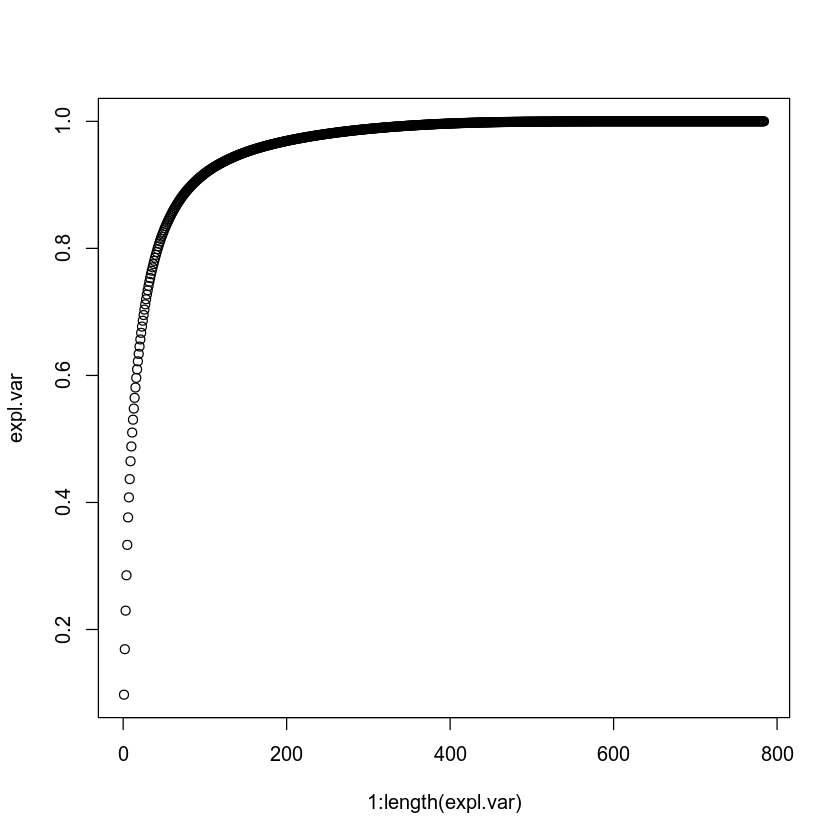

In [99]:
## Explained variace by each PC:
expl.var <- cumsum((PCA$sdev^2)/sum(PCA$sdev^2))
plot(1:length(expl.var), expl.var)


Tomando aprox. las 200 primeras PCs se captura un 95% de la varianza total.

In [100]:
# Dimension reduction considering the first 200 PCs for the clustering:
Npc <- 200
mnistReduced <- PCA$x[, 1:Npc]
kmModel.pca <- kmeans(mnistReduced, centers = 10, nstart = 10, iter.max = 1000)

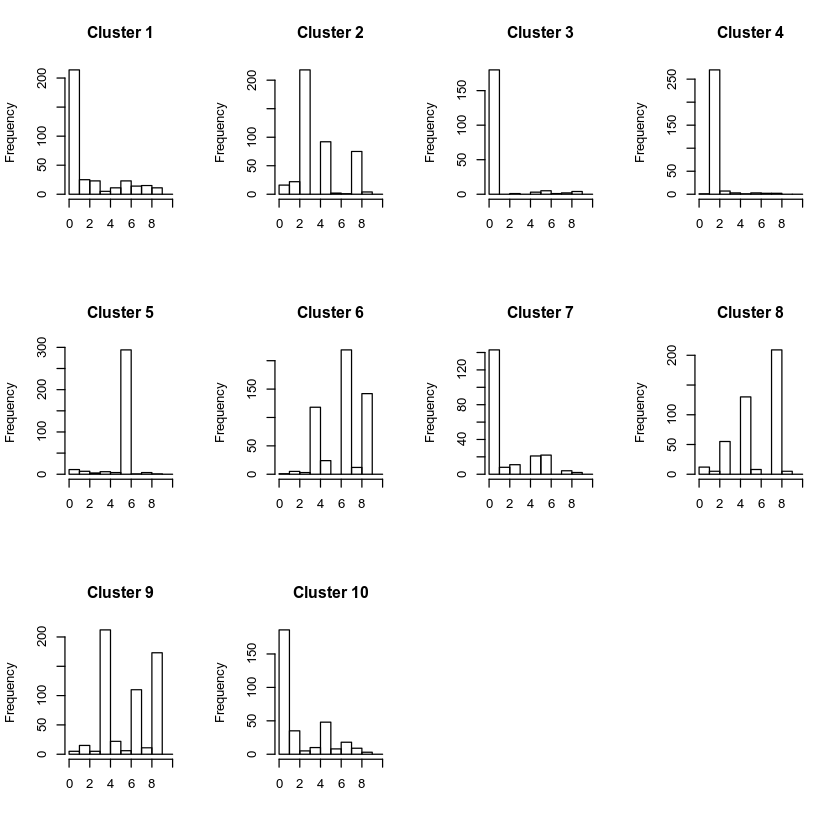

In [101]:
par(mfrow = c(3, 4))
drawFrequencies(kmeans.object = kmModel.pca, labels = mnist_data$label)


Representación de los centroides de las PCA:

In [102]:
# Project data onto PCs:
projected <- scale(as.matrix(kmModel.pca$centers) %*% t(as.matrix(PCA$rotation[, 
    1:Npc])), PCA$center, PCA$scale)

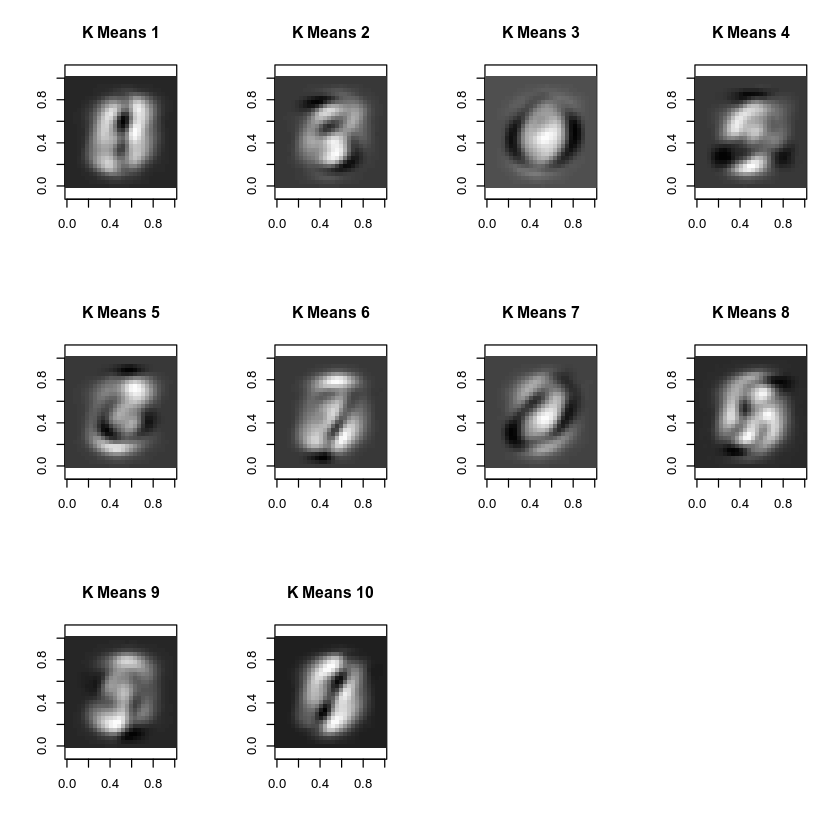

In [103]:
# Building a 3*3 grid
par(mfrow=c(3,4))
for (i in 1:10){
  # Changing i-th center to matrix
  mat <- matrix(rev(as.numeric(projected[i,])), nrow = 28, ncol = 28, byrow = FALSE)
  # plot
  image(mat[28:1, ], main=paste0("K Means ", i), col=paste("gray", 99:1, sep = ""), asp = 1)
}

#### Pregunta 5:
¿cómo afecta el uso de componentes principales al rendimiento de la clasificación no supervisada obtenida con el k-means? ¿Cómo lo explicarías?

### Ejemplo 3. Clustering divisivo

En esta sección, repetiremos el ejercicio de aprendizaje no supervisado para la clasificación de caracteres MNIST, aplicando otro algoritmo de amplia utilización, en este caso el clustering jerárquico aglomerativo, que es posiblemente junto con k-medias uno de los más utilizados en tareas de agrupamiento.

Como se ha visto, el input para este método es una matriz de distancias. El cálculo de dicha matriz es computacionalmente costoso (O(N^2)). Puede repetirse este ejercicio con más tiempo utilizando todo el conjunto de datos MNIST (>40,000 registros), si bien el tiempo de cálculo puede ser muy dilatado.


Además, se recomienda el uso de una librería de R alternativa para el cálculo de matrices de distancias, el paquete `parallelDist`, que permite paralelizar el cálculo de manera transparente al usuario, acelerando notablemente los cálculos. Los nombres de los argumentos y la salida son similares a la función de R nativa `dist` para maximizar su compatibilidad, salvando que en este caso la entrada ha de ser forzosamente una matriz (`matrix-class`), no adminitiendo un `data.frame` como en el caso de `dist`

In [11]:
if (!require("parallelDist")) {
    install.packages("parallelDist")
    library("parallelDist")
}

Loading required package: parallelDist



En este ejemplo, consideramos la distancia euclídea:

In [12]:
dist.euclidean <- parDist(as.matrix(mnist_data), method = "euclidean")

Una vez calculada la matriz de distancias, se realiza el clustering:

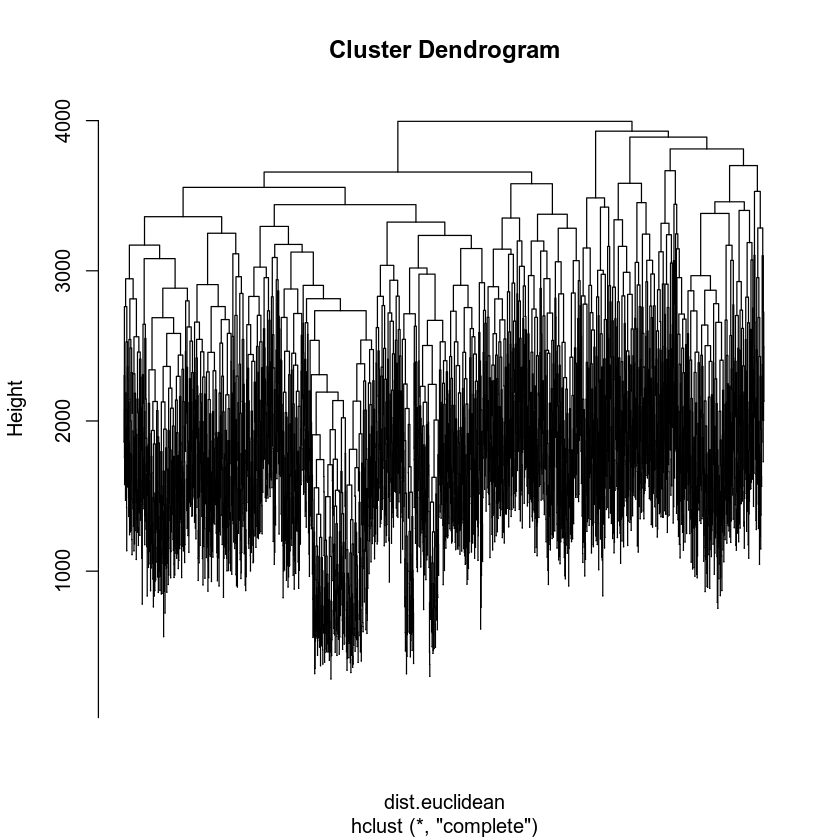

In [13]:
hc <- hclust(dist.euclidean)
plot(hc, hang = F, labels = F)

Analizamos el espacio de la partición considerando 10 grupos diferentes, que se corresponderian con el objetivo de nuestra clasificación:

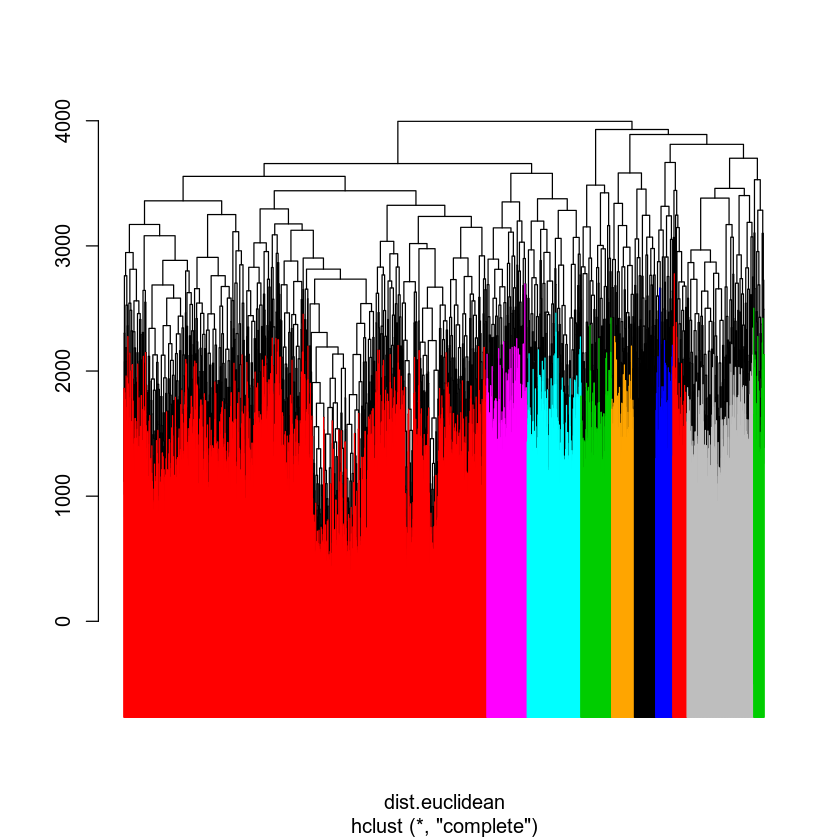

In [14]:
hc10 <- cutree(hc, k = 10)
sparcl::ColorDendrogram(hc, y = hc10, branchlength = 3000)

Al igual que anteriormente, analizamos la frecuencia de cada clase predicha en cada cluster, lo que nos permite hacernos una idea de la bondad de la clasificación. En este caso, observamos grupos que obtienen una elevado consenso en la clasificación, y otros muy heterogéneos:

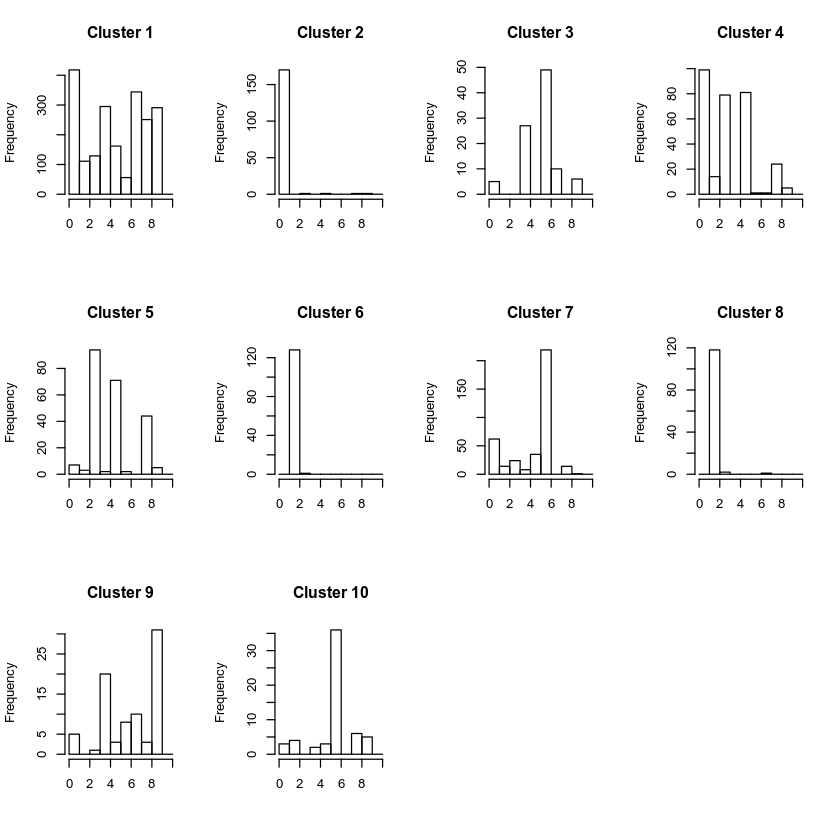

In [16]:
par(mfrow = c(3, 4))
for (i in 1:10) {
    hist(mnist_data$label[which(hc10 == i)], xlab = "", main = paste("Cluster", i), 
        breaks = seq(0, 10, 1))
}

Confirmamos esta impresión observando el valor de los centroides, al igual que hicimos con k-medias. Algunos números se identifican claramente, mientras que otros no resultan reconocibles:

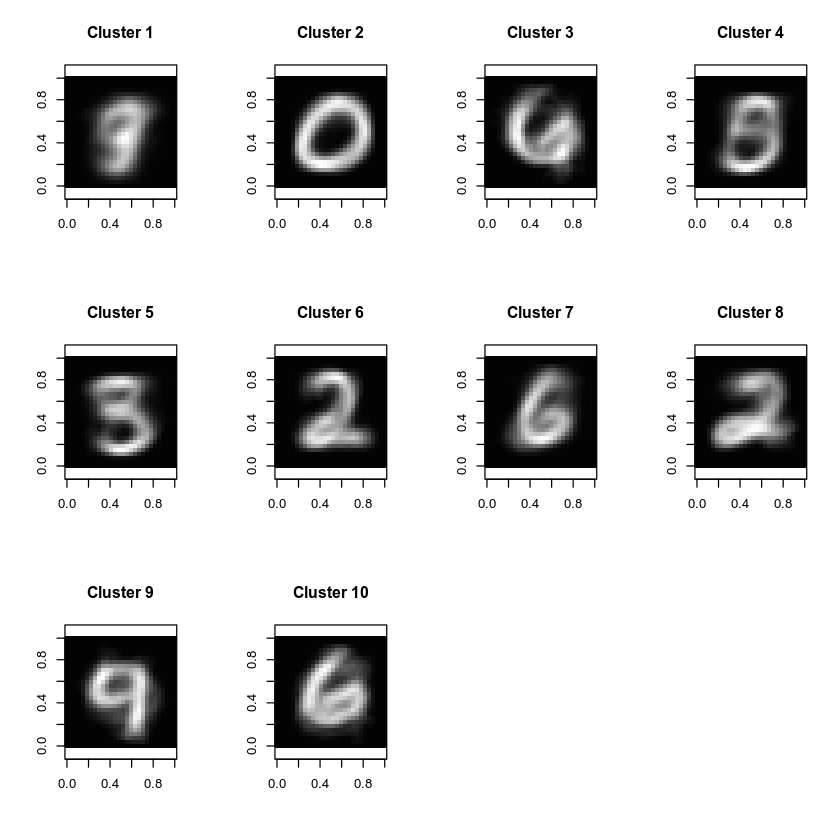

In [18]:
par(mfrow = c(3, 4))
for (i in 1:10) {
    ## Extract centroids:
    centroid.i <- apply(mnist_data[which(hc10 == i), -1], MARGIN = 2, FUN = "mean")
    # Converting i-th center to matrix
    mat <- matrix(rev(as.numeric(centroid.i)), nrow = 28, ncol = 28, byrow = FALSE)
    # plot (with a trick to re-order adequately for visualization)
    image(mat[28:1, ], main = paste("Cluster", i), col = paste("gray", 1:99, sep = ""), 
        asp = 1)
}

### Actividad propuesta

Los resultados de la clasificación no son muy buenos (hay que tener en cuenta la fuerte reducción en el número de casos que hemos impuesto de los 42.000 originales del conjunto de datos MNIST). Existen diversos parámetros que pueden influir de manera notable en la bondad del agrupamiento, destacando dos: la fución de _linkage_ utilizada y la medida de distancia entre muestras empleada. Se sugiere al alumno experimentar con algunos valores alternativos de estos parámetros, y comparar la bondad de la clasificación con el métoo k-medias empleado anteriormente.

<!--
Considerar dos cifras, una bien y otra mal discriminada por el método de clustering, aplicar un modelo de clasificación antes y después de hacer el clustering y comparar los resultados. Interpretad los resultados en base a la capacidad de discriminación de cada cifra obtenida en el proceso de clustering.
-->

## Session Info

In [112]:
print(sessionInfo())

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/juaco/miniconda3/envs/atlas/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] parallelDist_0.2.4 sparcl_1.0.4       fields_12.5        viridis_0.6.1     
 [5] viridisLite_0.4.0  spam_2.7-0         dotCall64_1.0-1    cluster_2.1.2     
 [9] kohonen_3.0.10     mclust_5.4.7       e1071_1.7-7        caret_6.0-88      
[13] ggplot2_3.3.5      lattice_0.20-44    MASS_7